# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp
import sys

import rapids_singlecell as rsc

import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

In [2]:
rsc.__version__

'0.3.2'

In [3]:
import rmm
rmm.reinitialize(
    managed_memory=False, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [4]:
data_load_start = time.time()

In [5]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.37 s, sys: 285 ms, total: 2.66 s
Wall time: 2.72 s


In [6]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [7]:
%%time
cudata = rsc.cunnData.cunnData(adata=adata)

CPU times: user 2.28 s, sys: 798 ms, total: 3.08 s
Wall time: 3.15 s


Verify the shape of the resulting sparse matrix:

In [8]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [9]:
cudata.nnz

114212920

In [10]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 5.936680555343628


## Preprocessing

In [11]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [12]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 4.88 ms, sys: 900 µs, total: 5.78 ms
Wall time: 5.64 ms


In [13]:
%%time
rsc.pp.flag_gene_family(cudata,gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 4.92 ms, sys: 0 ns, total: 4.92 ms
Wall time: 4.83 ms


In [14]:
%%time
rsc.pp.caluclate_qc(cudata,qc_vars=["MT","RIBO"])

CPU times: user 372 ms, sys: 56.7 ms, total: 429 ms
Wall time: 544 ms


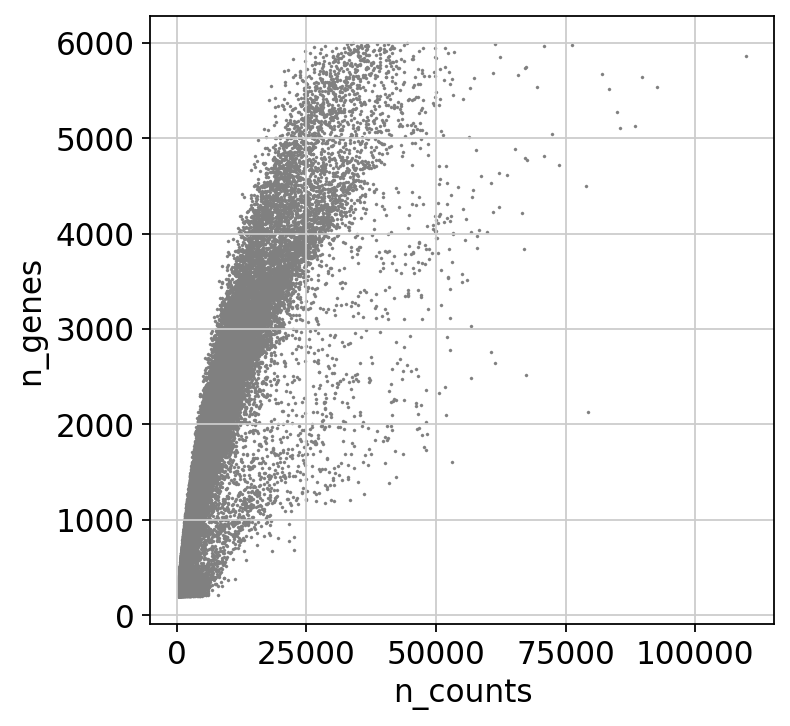

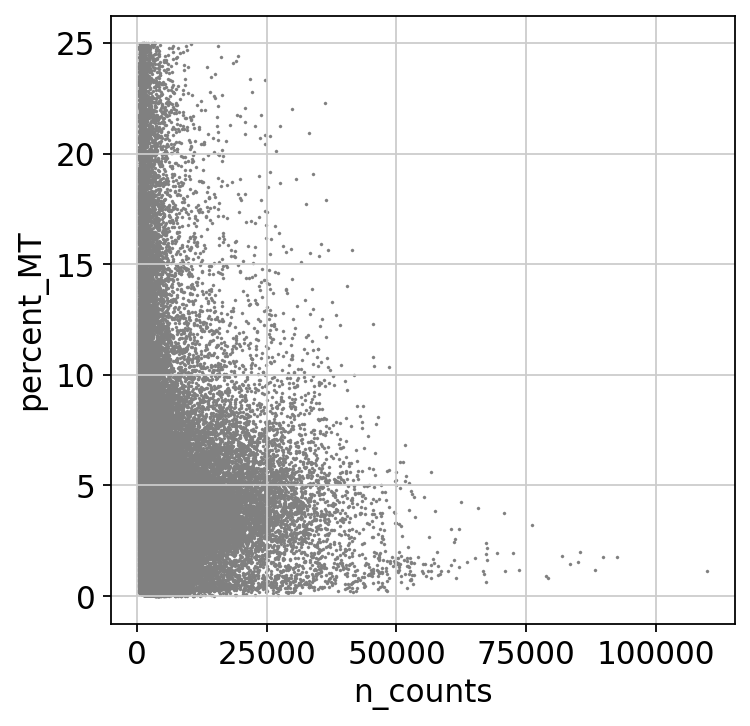

In [15]:
rsc.pp.plt_scatter(cudata,"n_counts","n_genes")
rsc.pp.plt_scatter(cudata,"n_counts","percent_MT")

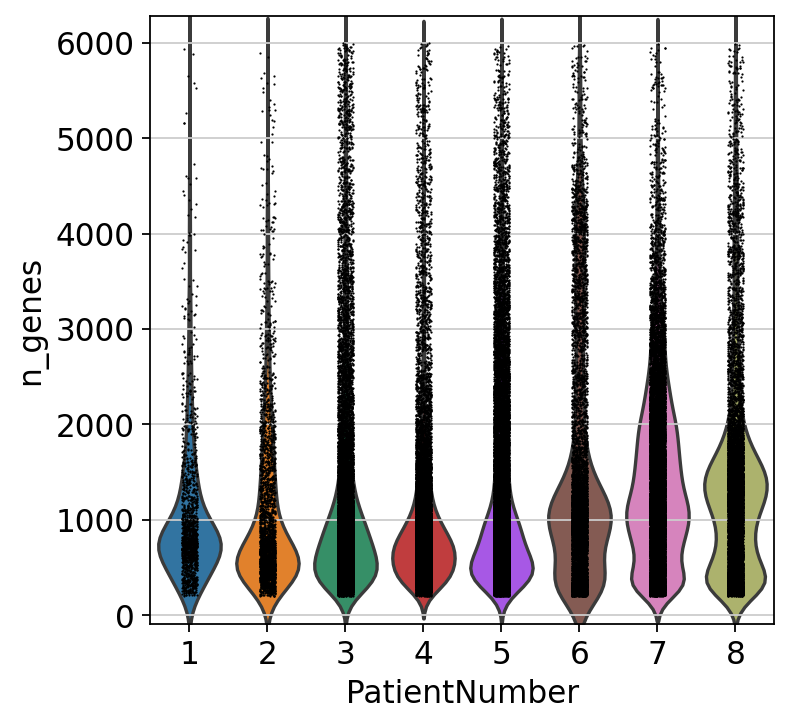

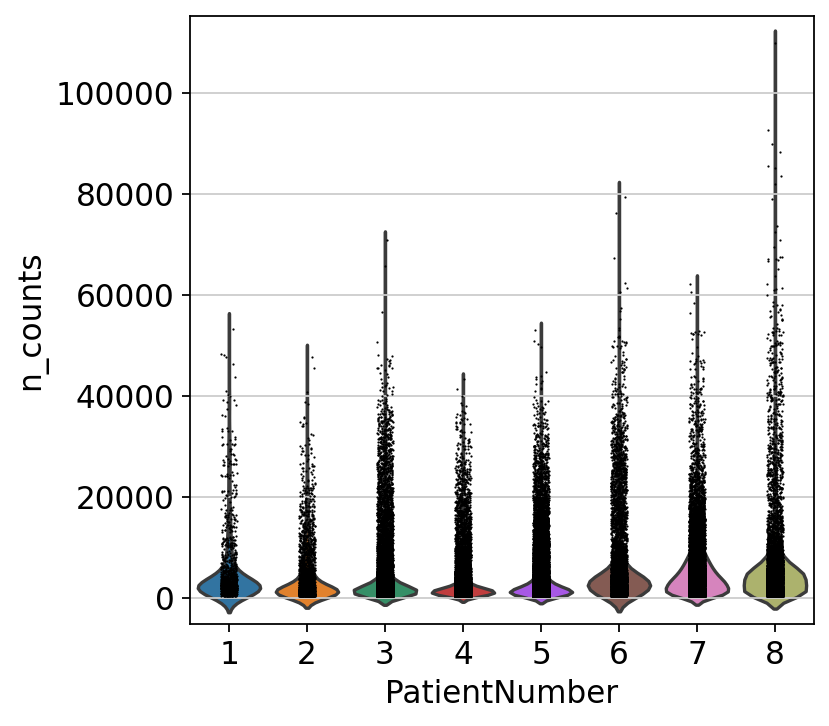

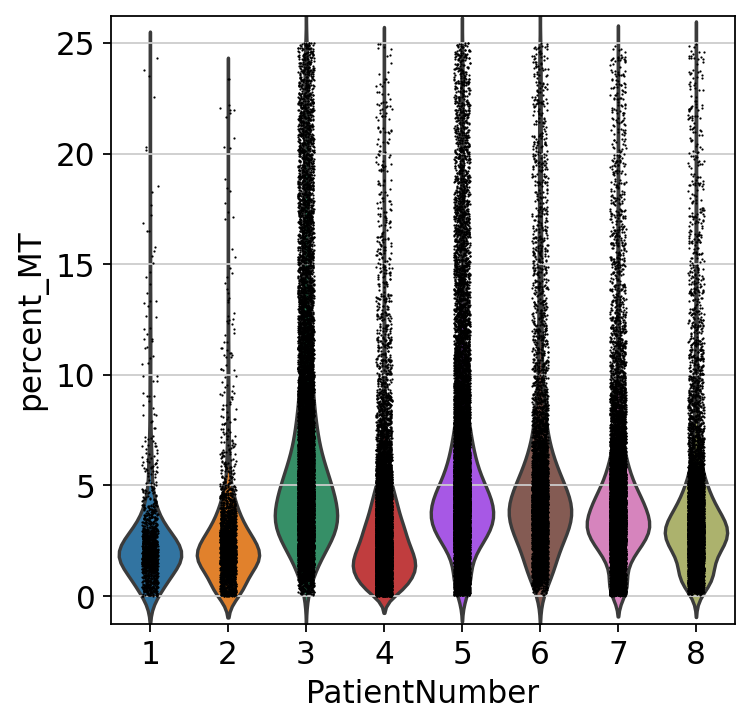

In [16]:
rsc.pp.plt_violin(cudata,key="n_genes",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="n_counts",groupby="PatientNumber")
rsc.pp.plt_violin(cudata,key="percent_MT",groupby="PatientNumber")

We store the raw expression counts in the `.layer["counts"]`

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [17]:
%%time
cudata = cudata[cudata.obs["n_genes"] < 5000]
cudata.shape

CPU times: user 7.53 ms, sys: 4.99 ms, total: 12.5 ms
Wall time: 11.7 ms


(92666, 33694)

In [18]:
%%time
cudata = cudata[cudata.obs["percent_MT"] < 20]
cudata.shape

CPU times: user 7.65 ms, sys: 2.35 ms, total: 10 ms
Wall time: 9.73 ms


(91180, 33694)

n_samplesWe also filter out genes that are expressed in less than 3 cells.

In [19]:
%%time
rsc.pp.filter_genes(cudata,min_count=3)

filtered out 8034 genes based on n_cells
CPU times: user 35 ms, sys: 13.1 ms, total: 48.1 ms
Wall time: 47.8 ms


In [20]:
cudata.layers["counts"] = cudata.X.copy()

In [21]:
cudata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [22]:
%%time
rsc.pp.normalize_total(cudata,target_sum=1e4)

CPU times: user 191 µs, sys: 395 µs, total: 586 µs
Wall time: 3.58 ms


Next, we log transform the count matrix.

In [23]:
%%time
rsc.pp.log1p(cudata)

CPU times: user 1.91 ms, sys: 2.82 ms, total: 4.74 ms
Wall time: 7.12 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [24]:
%%time
rsc.pp.highly_variable_genes(cudata,n_top_genes=5000,flavor="seurat_v3",batch_key= "PatientNumber",layer = "counts")

CPU times: user 1.07 s, sys: 3.2 s, total: 4.27 s
Wall time: 605 ms


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [25]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 230 ms, sys: 106 ms, total: 335 ms
Wall time: 335 ms


Now we restrict our cunndata object to the highly variable genes.

In [26]:
%%time
cudata = cudata[:,cudata.var["highly_variable"]==True]

CPU times: user 43.7 ms, sys: 24.4 ms, total: 68.1 ms
Wall time: 67.7 ms


In [27]:
cudata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [28]:
%%time
rsc.pp.regress_out(cudata,keys=["n_counts", "percent_MT"])

CPU times: user 1.12 s, sys: 918 ms, total: 2.04 s
Wall time: 2.1 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [29]:
%%time
rsc.pp.scale(cudata,max_value=10)

CPU times: user 106 ms, sys: 4.05 ms, total: 110 ms
Wall time: 127 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [30]:
%%time
rsc.pp.pca(cudata, n_comps = 100)

CPU times: user 699 ms, sys: 87.7 ms, total: 787 ms
Wall time: 798 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

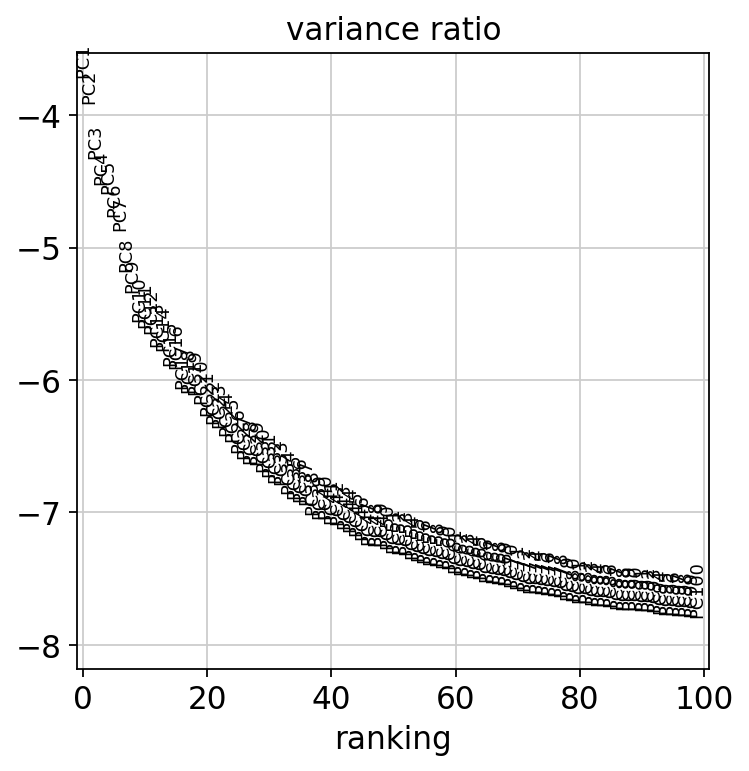

In [31]:
sc.pl.pca_variance_ratio(cudata, log=True,n_pcs=100)

Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [32]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata, cudata

CPU times: user 283 ms, sys: 181 ms, total: 464 ms
Wall time: 464 ms


In [33]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 7.552404165267944


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [34]:
%%time
rsc.tl.harmony_integrate(adata,key="PatientNumber")

2023-01-11 13:16:48,457 - harmonypy_gpu - INFO - Computing initial centroids with cuml.KMeans...
2023-01-11 13:16:48,586 - harmonypy_gpu - INFO - cuml.KMeans initialization complete.
2023-01-11 13:16:48,724 - harmonypy_gpu - INFO - Iteration 1 of 10
2023-01-11 13:16:51,647 - harmonypy_gpu - INFO - Iteration 2 of 10
2023-01-11 13:16:54,163 - harmonypy_gpu - INFO - Iteration 3 of 10
2023-01-11 13:16:57,035 - harmonypy_gpu - INFO - Iteration 4 of 10
2023-01-11 13:16:59,152 - harmonypy_gpu - INFO - Iteration 5 of 10
2023-01-11 13:17:02,025 - harmonypy_gpu - INFO - Iteration 6 of 10
2023-01-11 13:17:04,544 - harmonypy_gpu - INFO - Converged after 6 iterations


CPU times: user 6.05 s, sys: 8.95 s, total: 15 s
Wall time: 16.2 s


In [35]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40, method='rapids')

CPU times: user 7.14 s, sys: 2.16 s, total: 9.3 s
Wall time: 6.33 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [36]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 398 ms, sys: 8.54 ms, total: 407 ms
Wall time: 405 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [37]:
%%time
rsc.tl.louvain(adata, resolution=0.6)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 242 ms, sys: 450 ms, total: 692 ms
Wall time: 1.03 s


In [38]:
%%time
rsc.tl.leiden(adata,resolution=0.6)

CPU times: user 117 ms, sys: 39.4 ms, total: 157 ms
Wall time: 157 ms


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


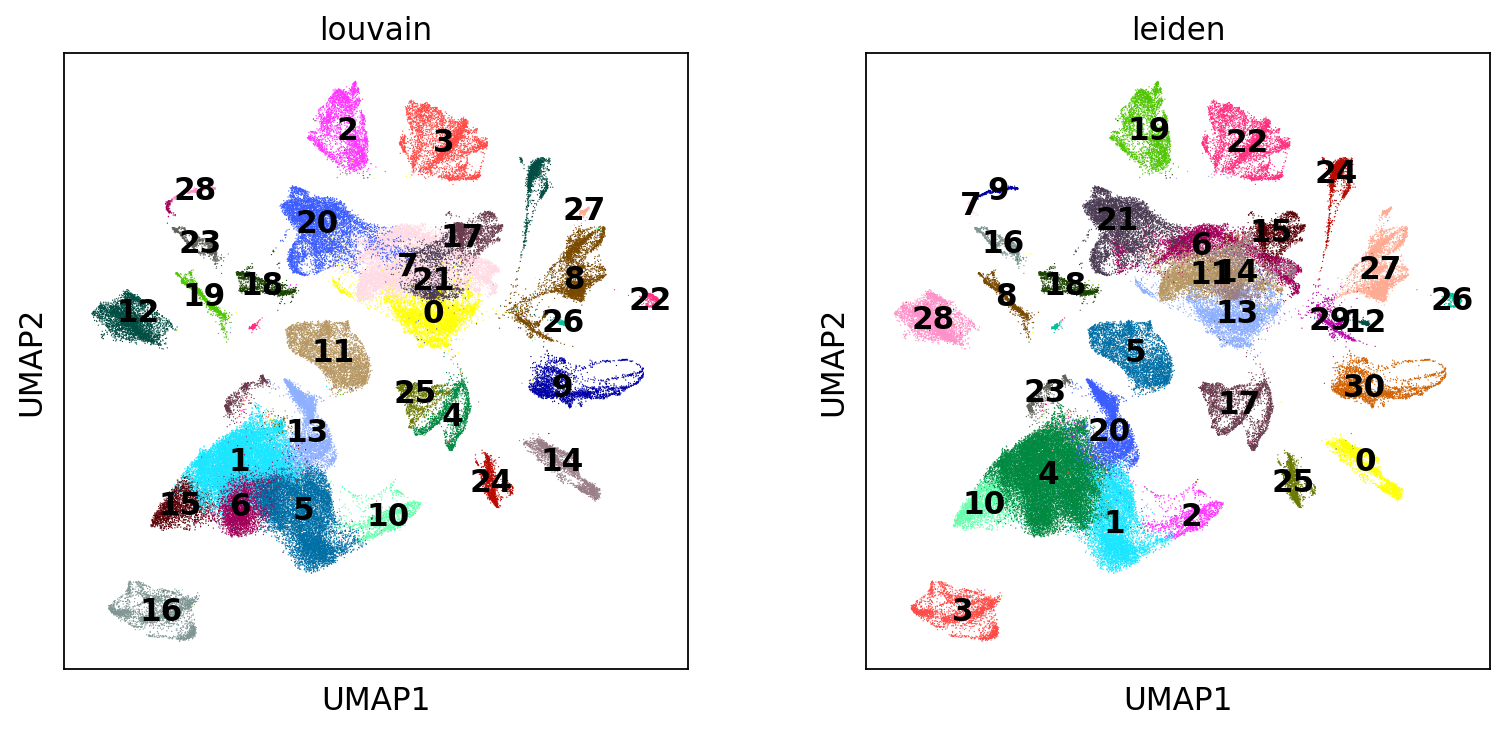

CPU times: user 695 ms, sys: 173 ms, total: 868 ms
Wall time: 691 ms


In [39]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


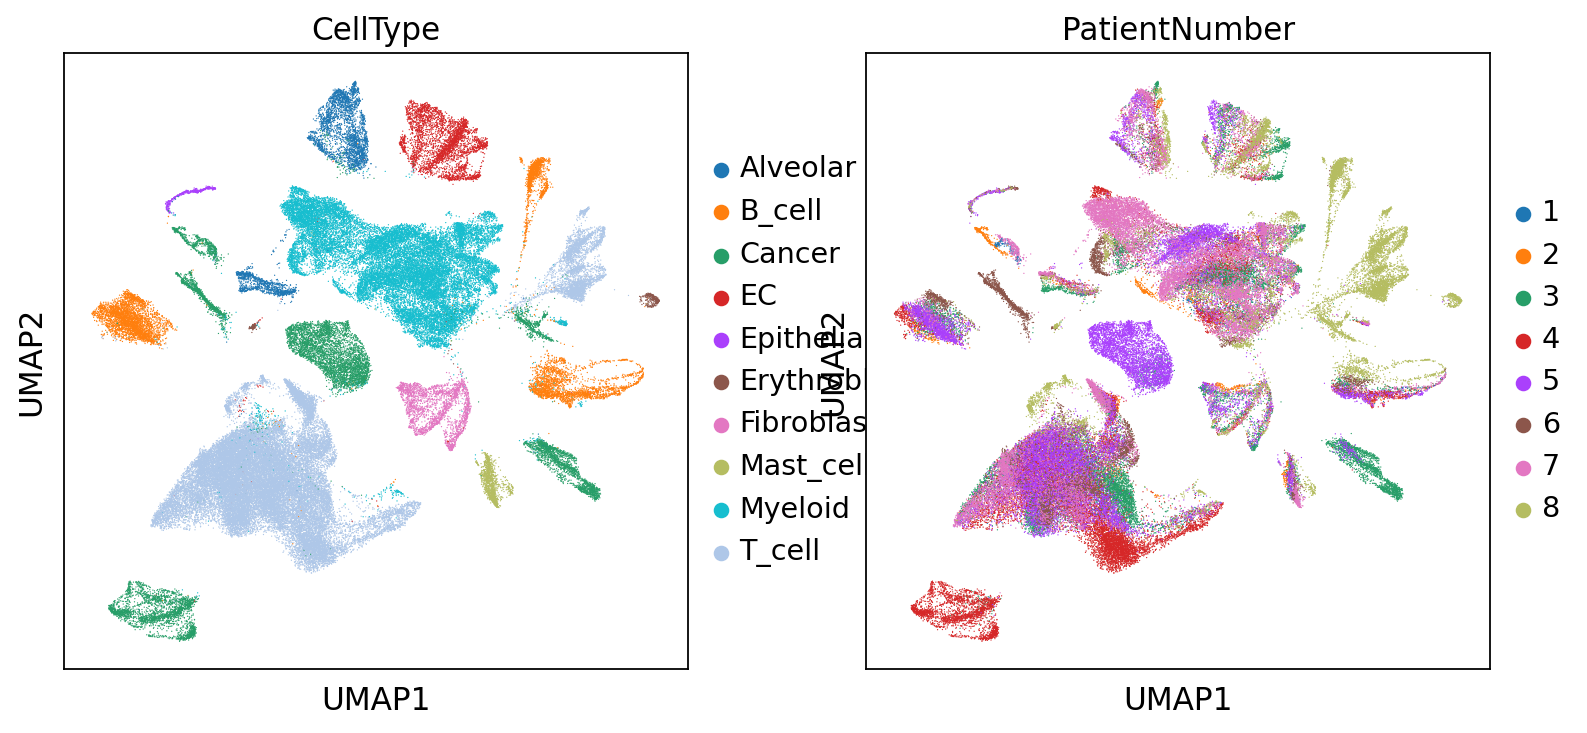

In [40]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

We also caluclate the embedding density in the UMAP using cuML

In [41]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 554 ms, sys: 85.3 ms, total: 639 ms
Wall time: 700 ms


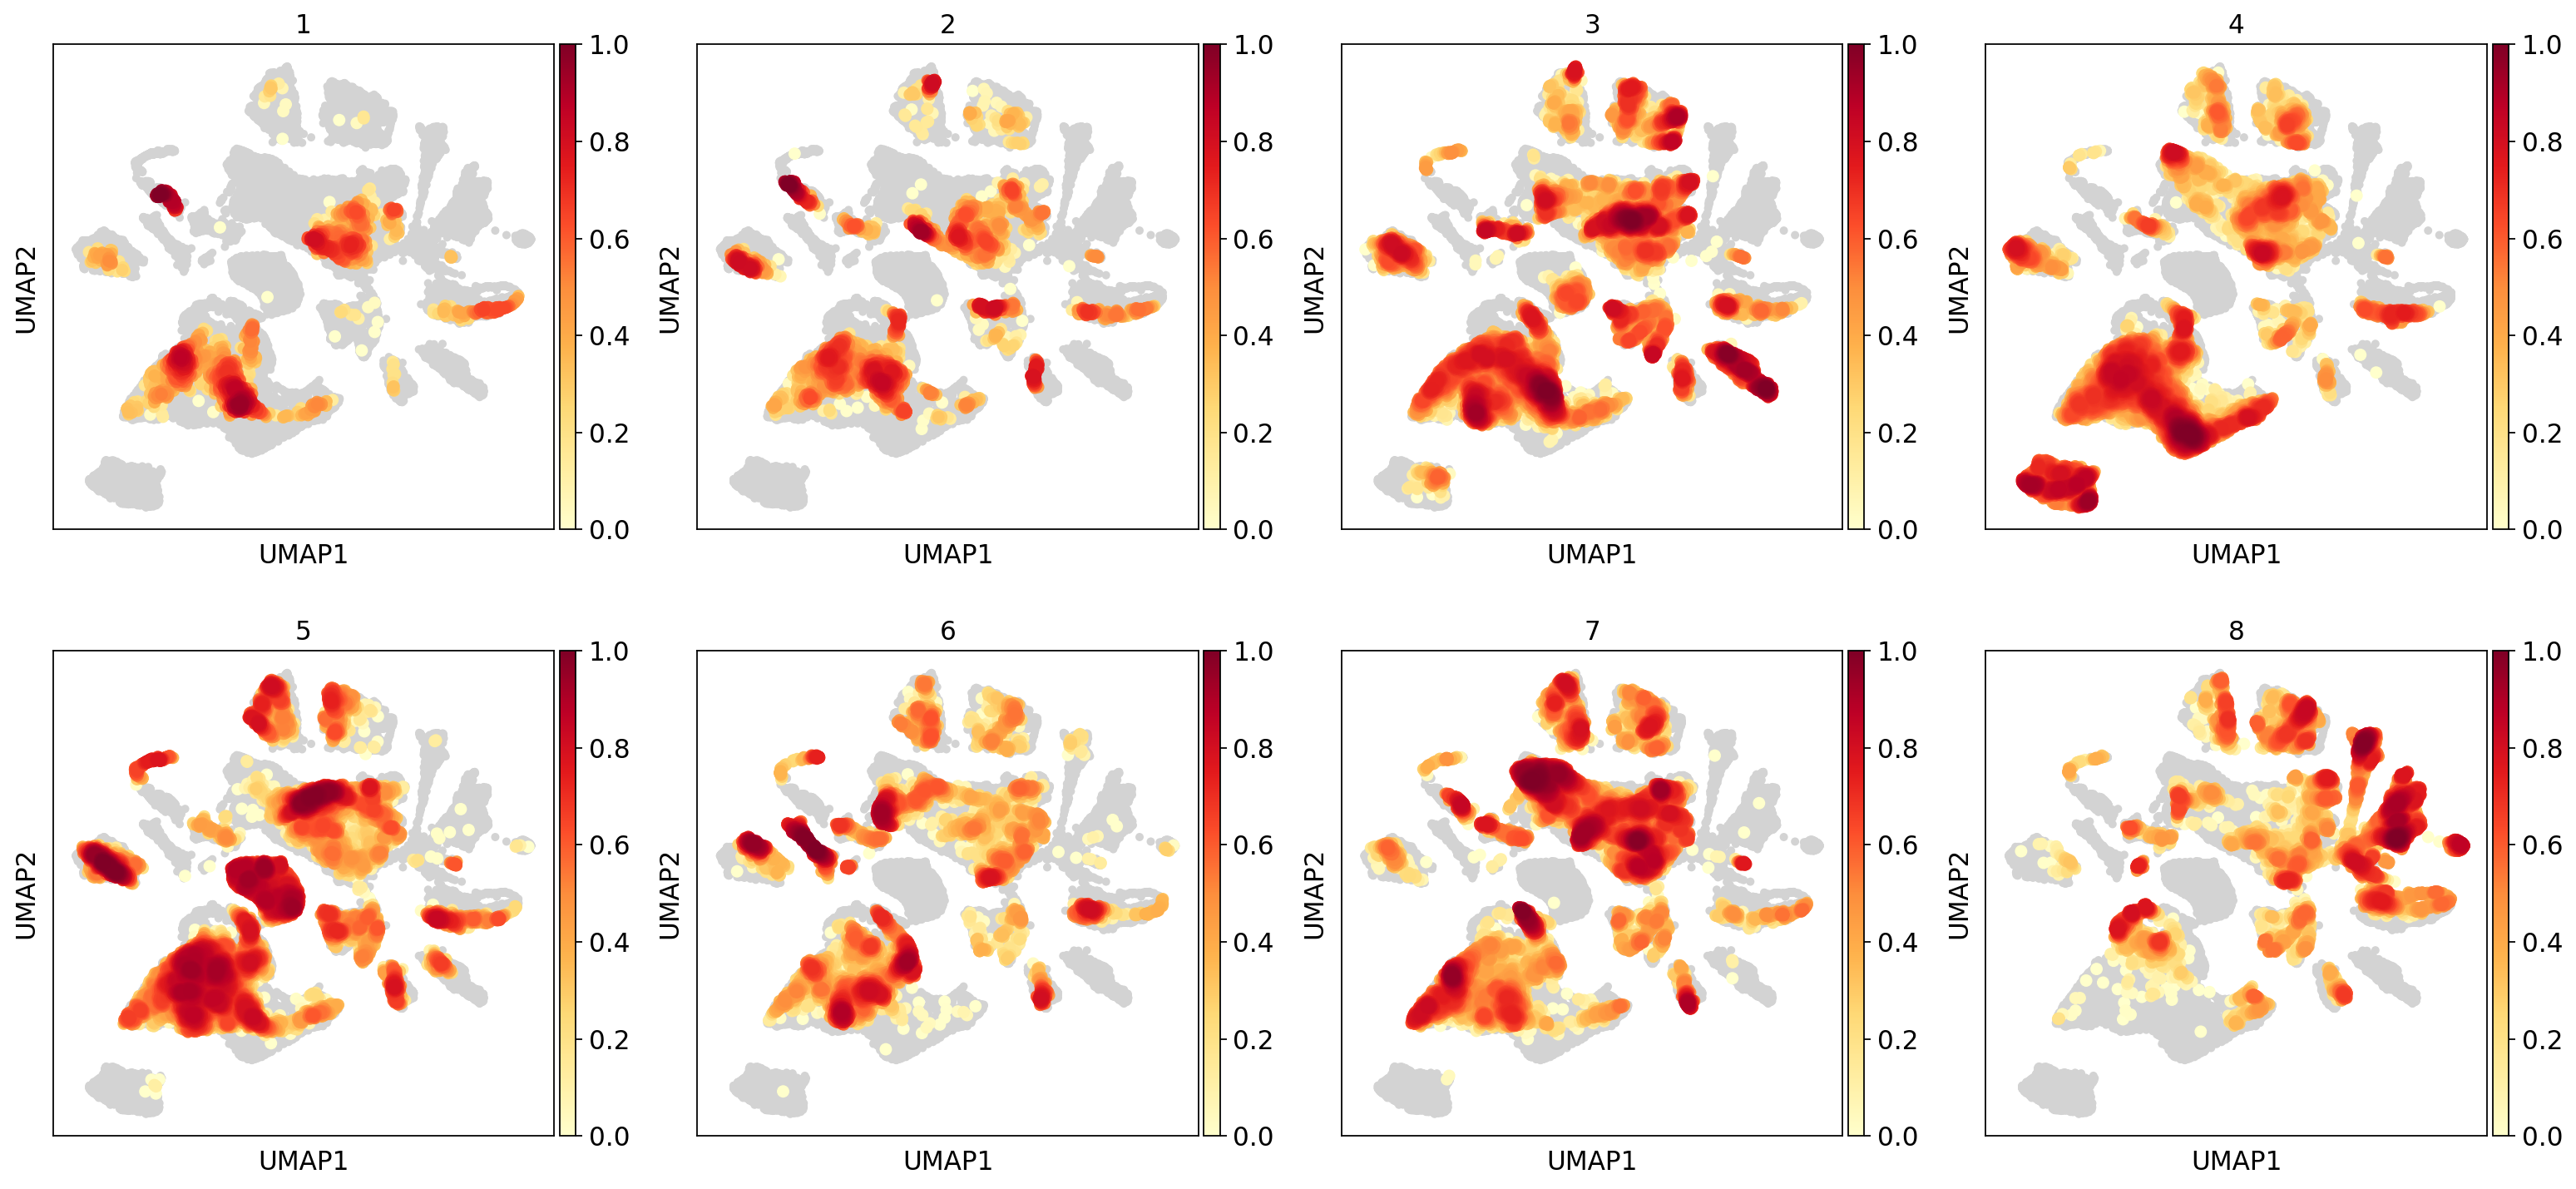

In [42]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [43]:
%%time
rsc.tl.tsne(adata, n_pcs = 40)

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [13:17:17.769259] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.55 s, sys: 23.8 ms, total: 1.57 s
Wall time: 1.57 s


In [44]:
rsc.tl.kmeans(adata, n_clusters=8)

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


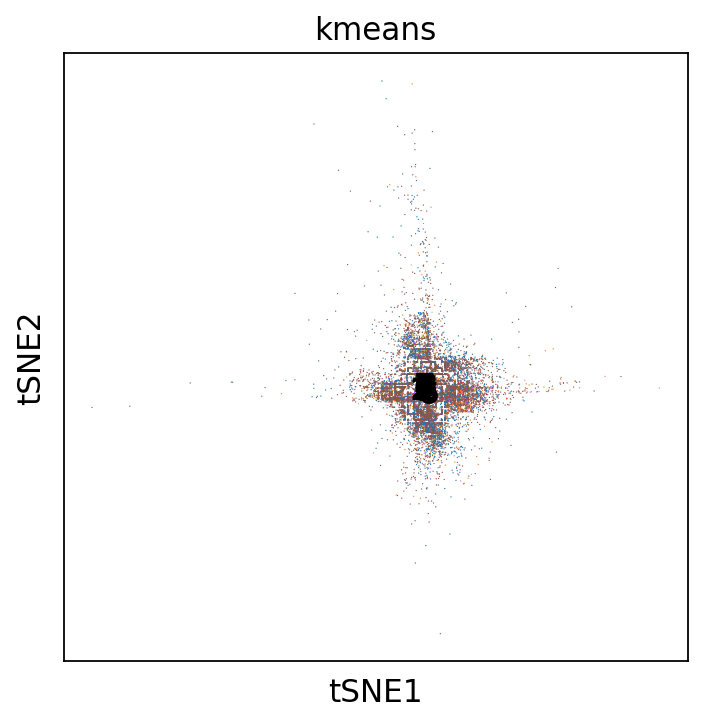

CPU times: user 341 ms, sys: 155 ms, total: 496 ms
Wall time: 314 ms


In [45]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


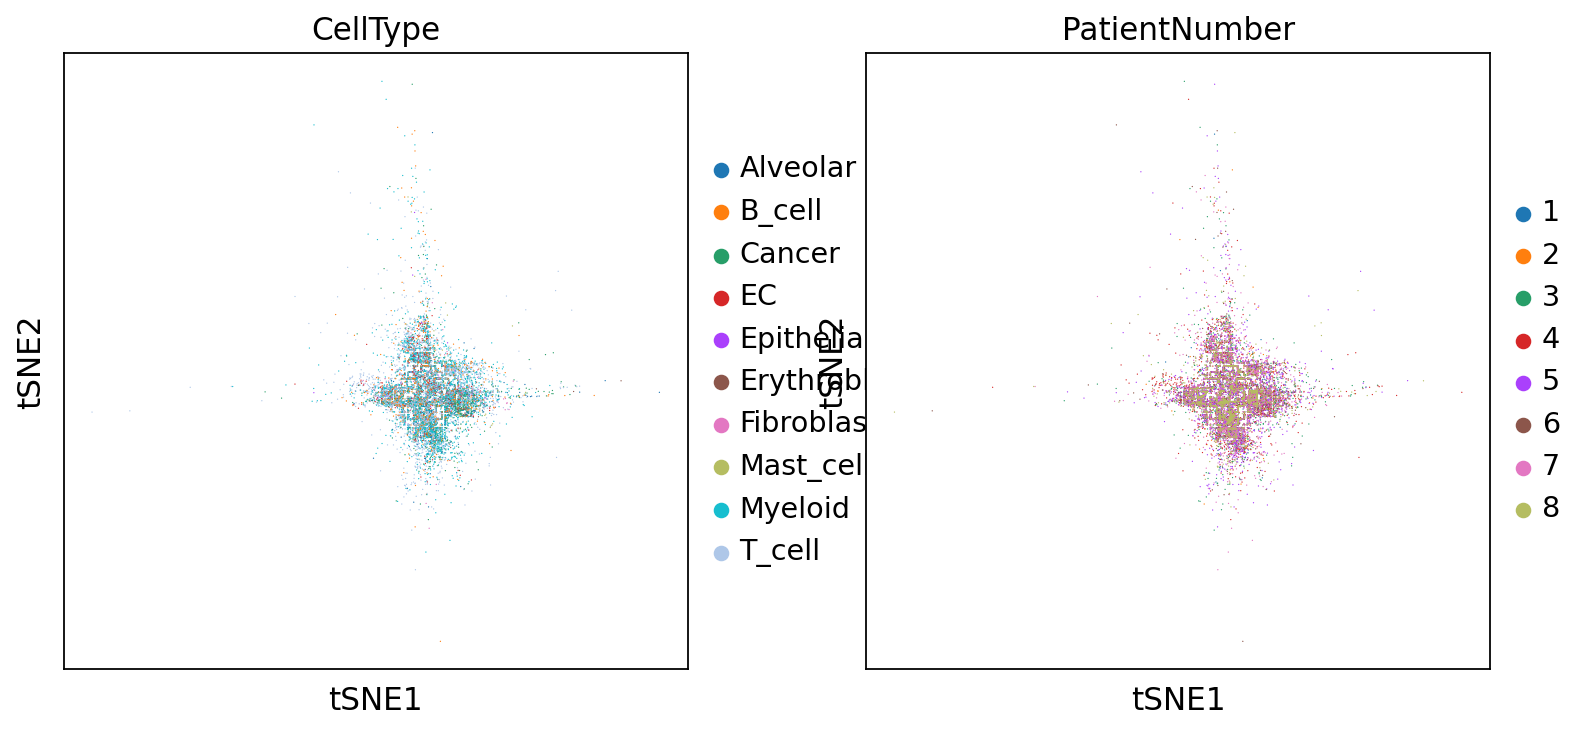

In [46]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [47]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 2.66 s, sys: 1.08 s, total: 3.74 s
Wall time: 3.78 s


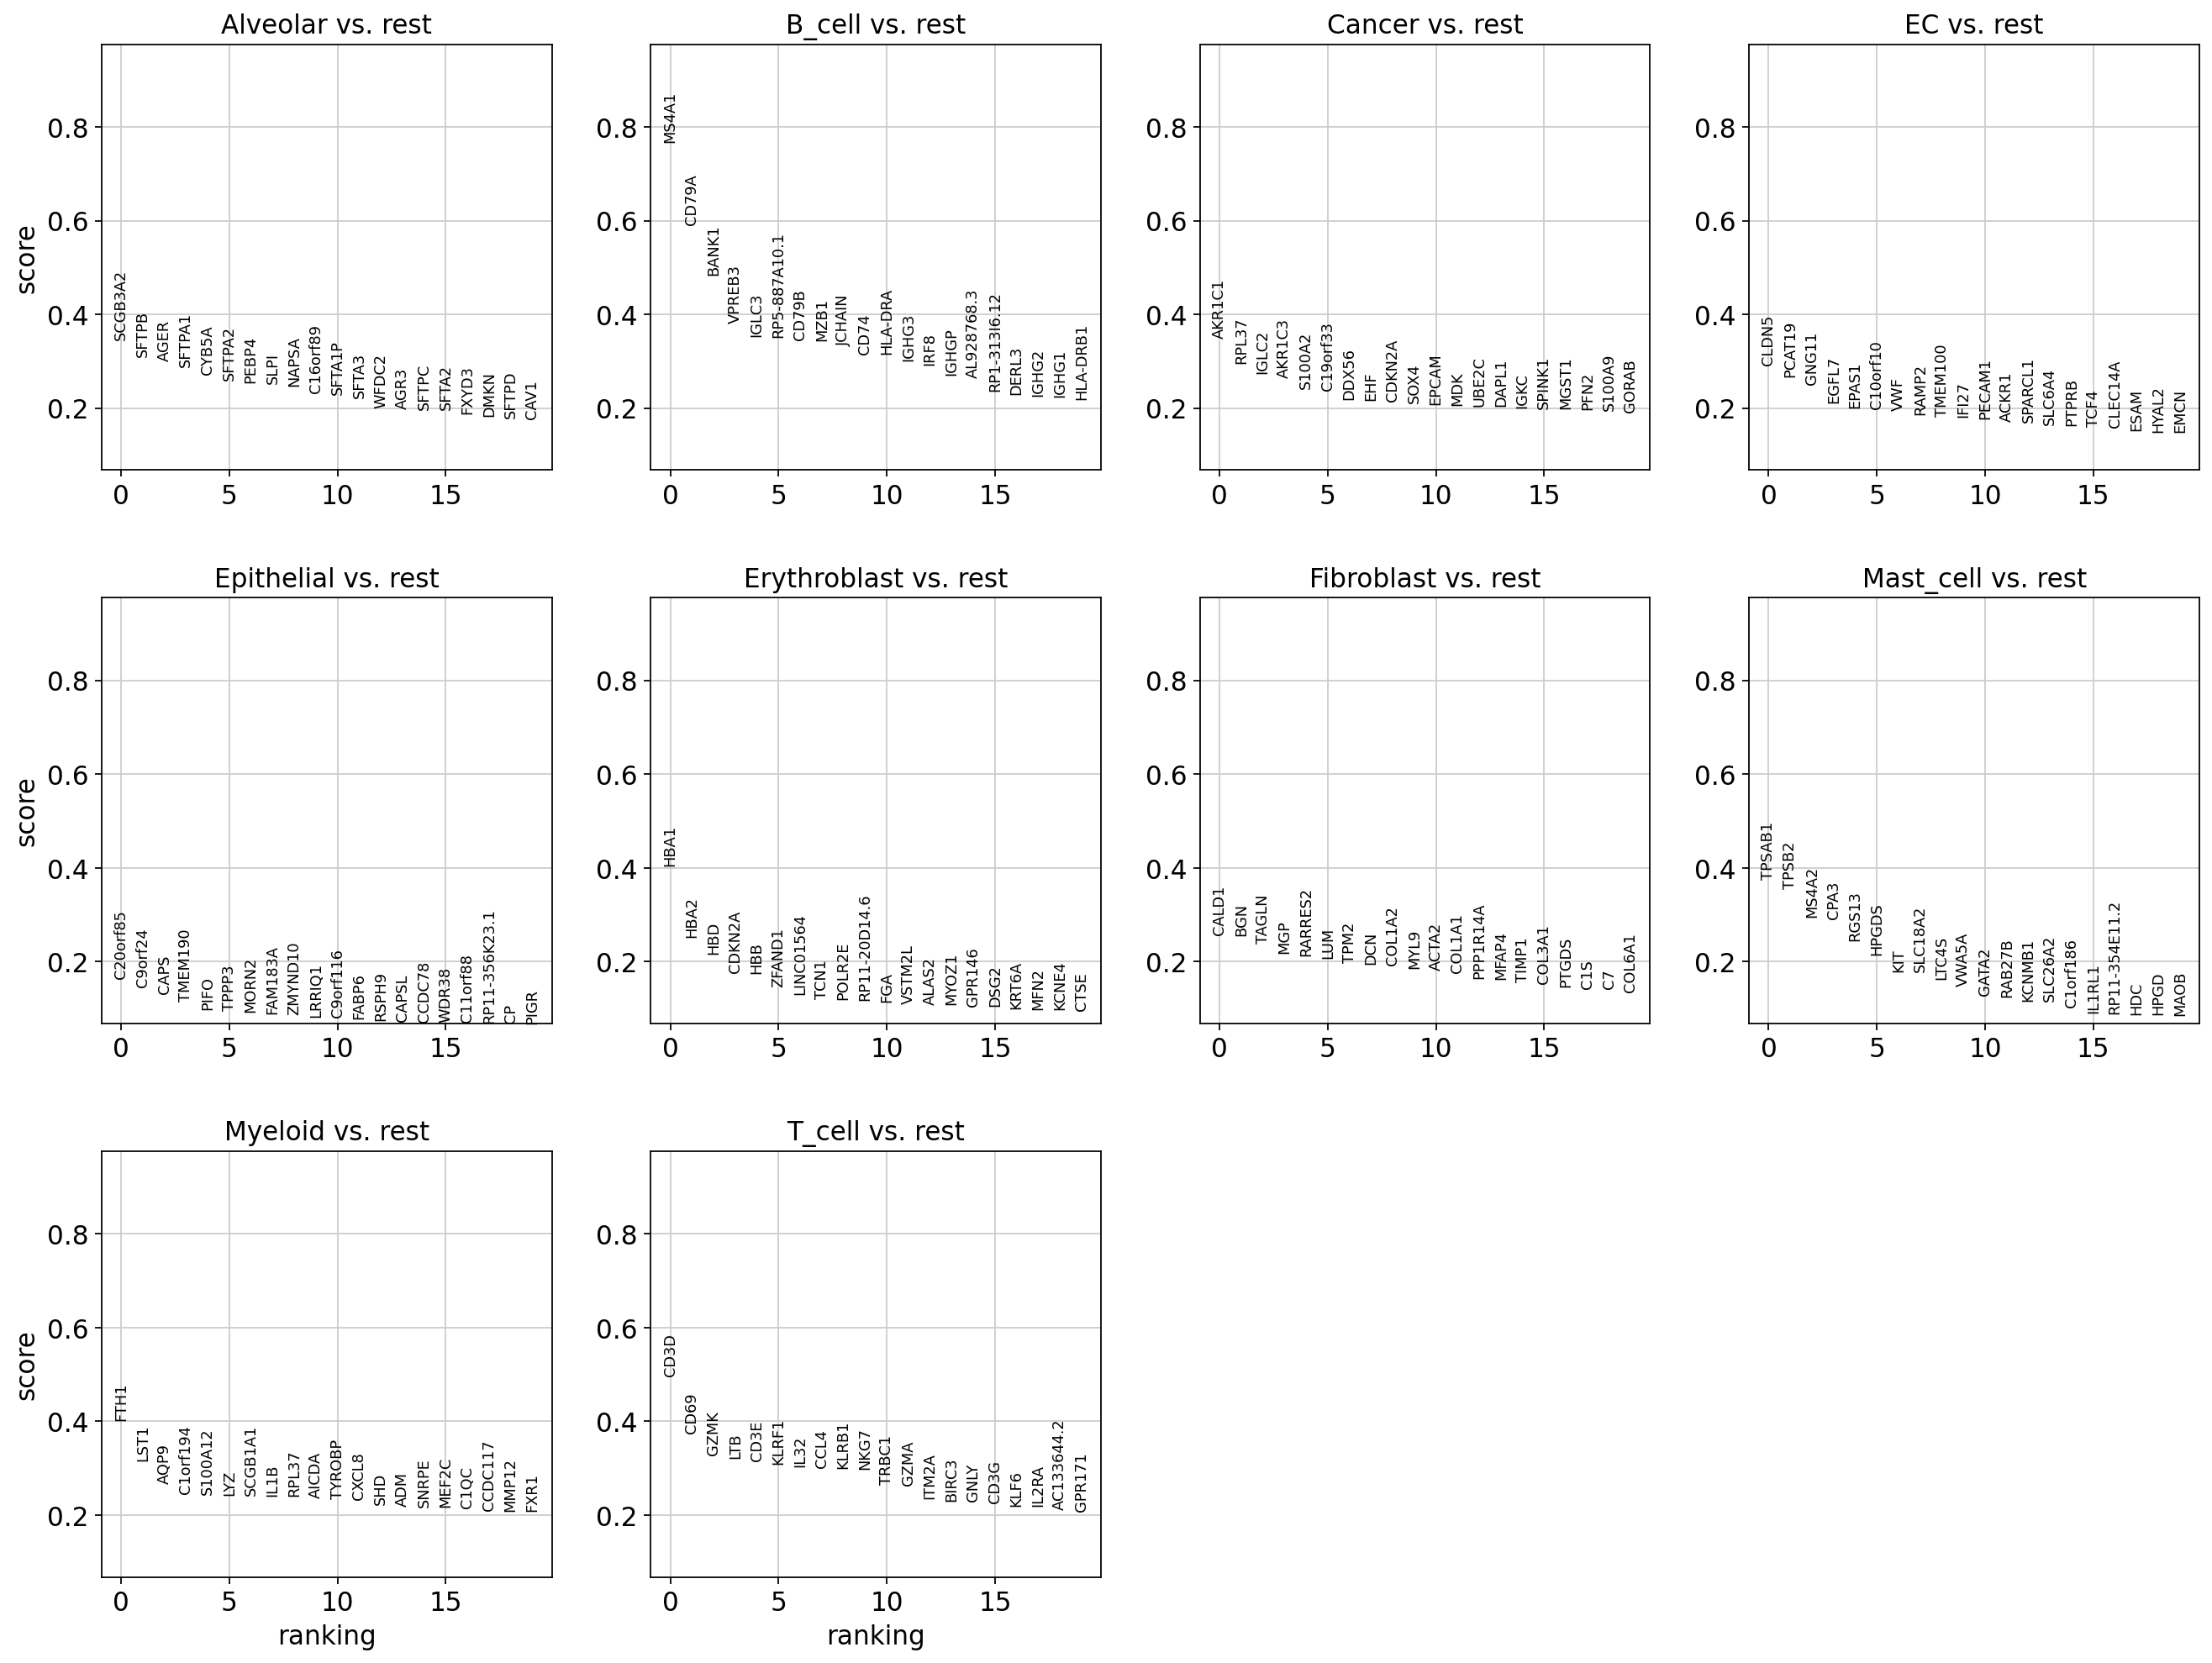

CPU times: user 903 ms, sys: 164 ms, total: 1.07 s
Wall time: 886 ms


In [48]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [49]:
post_time = time.time()

In [50]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 36.83786153793335


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [51]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:].copy()

We can repeat the dimension reduction, clustering and visulatization.

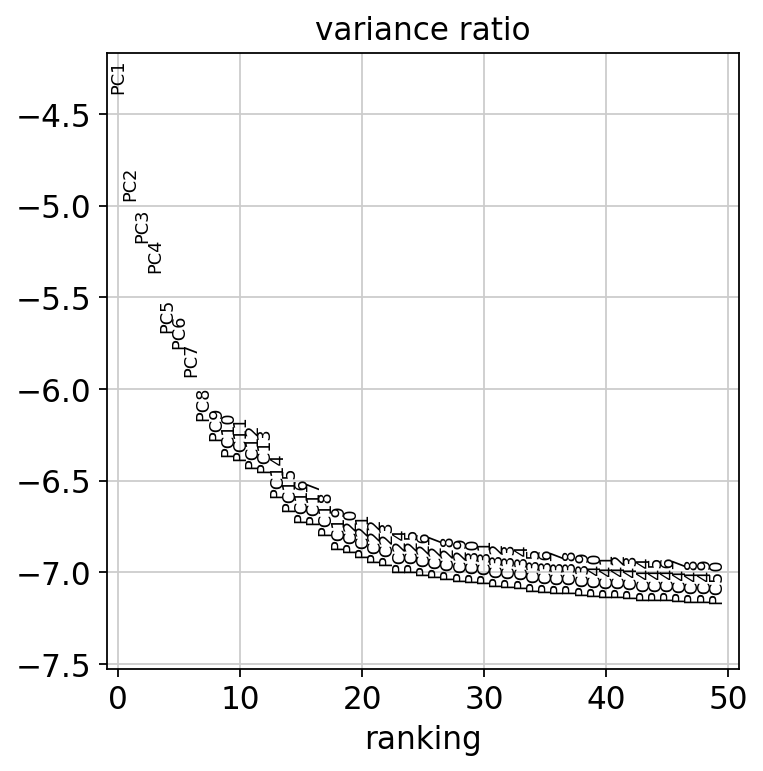

CPU times: user 988 ms, sys: 470 ms, total: 1.46 s
Wall time: 1.28 s


In [52]:
%%time
rsc.tl.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [53]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsc.tl.leiden(tdata)

CPU times: user 871 ms, sys: 224 ms, total: 1.1 s
Wall time: 851 ms


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


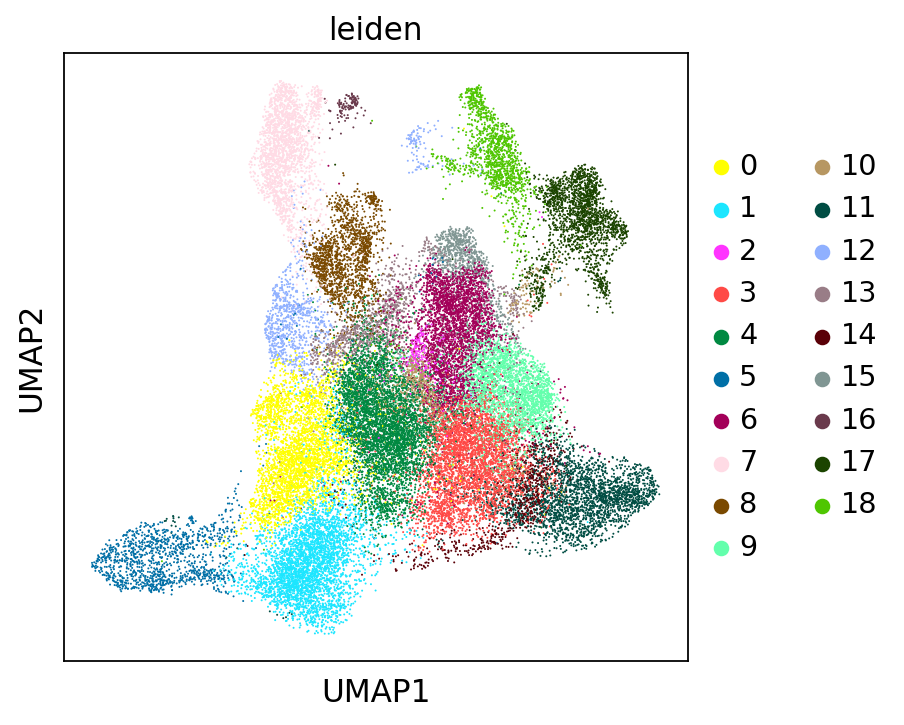

In [54]:
sc.pl.umap(tdata, color=["leiden"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [55]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 358 ms, sys: 1.15 s, total: 1.5 s
Wall time: 171 ms


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


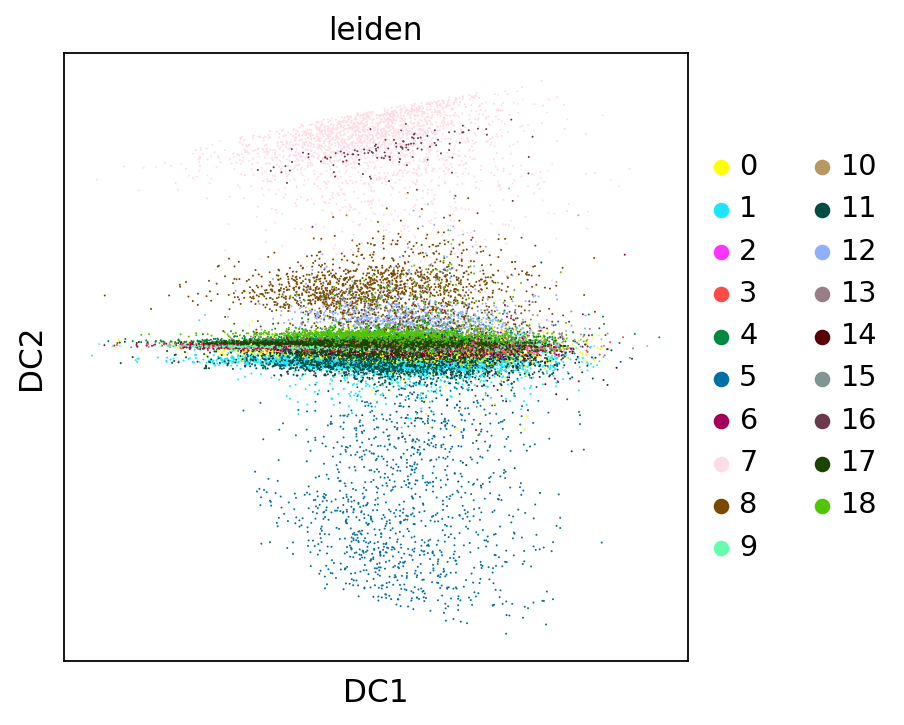

In [56]:
sc.pl.diffmap(tdata, color='leiden')

In [57]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 338 ms, sys: 9.35 ms, total: 347 ms
Wall time: 375 ms


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


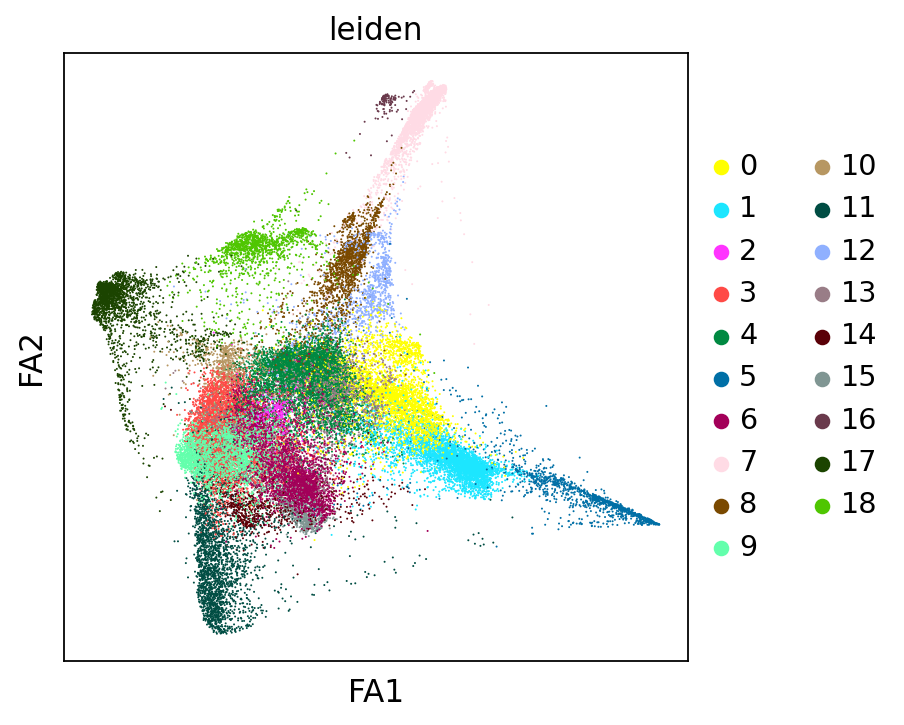

In [58]:
sc.pl.draw_graph(tdata, color='leiden')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [59]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 48.5746808052063
